C:\Users\N-ESS\anaconda3\envs\gesture_recognition\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


📹 INFÉRENCE TEMPS RÉEL - RECONNAISSANCE DE GESTES

📦 Versions :
   - OpenCV     : 4.12.0
   - TensorFlow : 2.20.0

📹 Test de la webcam...

✅ Webcam détectée et ouverte
✅ Frame capturée avec succès
   - Résolution : 640x480
   - Channels   : 3


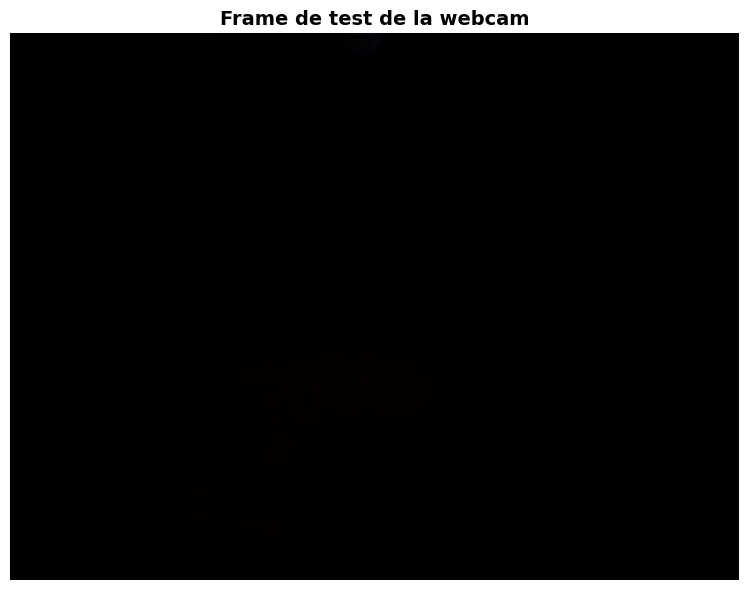


💡 Si vous voyez votre image ci-dessus, la webcam fonctionne !

✅ Test webcam terminé


In [1]:
# =============================================================================
# NOTEBOOK 07 : INFÉRENCE EN TEMPS RÉEL AVEC WEBCAM
# =============================================================================
# Objectif : Détecter et classifier les gestes de la main en temps réel
#            via webcam avec MediaPipe + CNN
# =============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras

print("="*70)
print("📹 INFÉRENCE TEMPS RÉEL - RECONNAISSANCE DE GESTES")
print("="*70)

print(f"\n📦 Versions :")
print(f"   - OpenCV     : {cv2.__version__}")
print(f"   - TensorFlow : {tf.__version__}")

# Test de la webcam
print(f"\n📹 Test de la webcam...\n")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Erreur : Impossible d'ouvrir la webcam")
    print("   Vérifiez que :")
    print("   - La webcam est connectée")
    print("   - Aucune autre application ne l'utilise")
    print("   - Les permissions sont accordées")
else:
    print("✅ Webcam détectée et ouverte")
    
    # Lire une frame de test
    ret, frame = cap.read()
    
    if ret:
        print(f"✅ Frame capturée avec succès")
        print(f"   - Résolution : {frame.shape[1]}x{frame.shape[0]}")
        print(f"   - Channels   : {frame.shape[2]}")
        
        # Afficher la frame
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Frame de test de la webcam', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 Si vous voyez votre image ci-dessus, la webcam fonctionne !")
    else:
        print("❌ Erreur lors de la capture de la frame")
    
    cap.release()

print(f"\n✅ Test webcam terminé")

In [2]:
# =============================================================================
# CHARGEMENT DU MODÈLE ENTRAÎNÉ
# =============================================================================

print("\n" + "="*70)
print("🧠 CHARGEMENT DU MODÈLE CNN")
print("="*70)

print(f"\n⏳ Chargement du modèle...\n")

# Charger le modèle
model = keras.models.load_model('models/gesture_model_final.keras')

print(f"✅ Modèle chargé avec succès")
print(f"   - Fichier    : models/gesture_model_final.keras")
print(f"   - Paramètres : {model.count_params():,}")

# Définir les classes
noms_classes = {
    0: "Poing fermé",
    1: "Paume ouverte",
    2: "Victoire (V)"
}

classes_labels = ["Poing", "Paume", "Victoire"]
couleurs_classes = {
    0: (255, 100, 100),  # Bleu (BGR)
    1: (100, 255, 100),  # Vert
    2: (100, 100, 255)   # Rouge
}

print(f"\n📊 Classes détectables :")
for i, nom in noms_classes.items():
    print(f"   {i} : {nom}")


🧠 CHARGEMENT DU MODÈLE CNN

⏳ Chargement du modèle...

✅ Modèle chargé avec succès
   - Fichier    : models/gesture_model_final.keras
   - Paramètres : 256,707

📊 Classes détectables :
   0 : Poing fermé
   1 : Paume ouverte
   2 : Victoire (V)


In [3]:
# =============================================================================
# FONCTIONS DE PRÉTRAITEMENT POUR L'INFÉRENCE
# =============================================================================

print("\n" + "="*70)
print("🔧 FONCTIONS DE PRÉTRAITEMENT")
print("="*70)

def pretraiter_pour_inference(image_bgr):
    """
    Prétraite une image BGR de la webcam pour l'inférence
    
    Paramètres :
    -----------
    image_bgr : array
        Image BGR de la webcam
    
    Retourne :
    ---------
    image_processed : array (1, 28, 28, 1)
        Image prétraitée prête pour le modèle
    """
    
    # 1. Convertir BGR en niveaux de gris
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    
    # 2. Redimensionner à 28x28
    image_resized = cv2.resize(image_gray, (28, 28), interpolation=cv2.INTER_AREA)
    
    # 3. Appliquer CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    image_clahe = clahe.apply(image_resized)
    
    # 4. Filtrage gaussien
    image_filtered = cv2.GaussianBlur(image_clahe, (3, 3), 0)
    
    # 5. Normalisation
    image_normalized = image_filtered.astype(np.float32) / 255.0
    
    # 6. Reshape pour le modèle (1, 28, 28, 1)
    image_processed = image_normalized.reshape(1, 28, 28, 1)
    
    return image_processed


def extraire_region_main(frame, x, y, w, h, marge=20):
    """
    Extrait une région carrée autour de la main détectée
    
    Paramètres :
    -----------
    frame : array
        Image complète
    x, y, w, h : int
        Coordonnées du rectangle de détection
    marge : int
        Marge à ajouter autour de la main
    
    Retourne :
    ---------
    roi : array
        Région d'intérêt carrée
    """
    
    height, width = frame.shape[:2]
    
    # Calculer le centre
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Prendre la plus grande dimension
    size = max(w, h) + marge * 2
    
    # Calculer les coordonnées du carré
    x1 = max(0, center_x - size // 2)
    y1 = max(0, center_y - size // 2)
    x2 = min(width, center_x + size // 2)
    y2 = min(height, center_y + size // 2)
    
    # Extraire la ROI
    roi = frame[y1:y2, x1:x2]
    
    return roi, (x1, y1, x2, y2)


print(f"\n✅ Fonctions de prétraitement définies")
print(f"   - pretraiter_pour_inference() : Prétraite une image pour le modèle")
print(f"   - extraire_region_main()      : Extrait une ROI carrée")


🔧 FONCTIONS DE PRÉTRAITEMENT

✅ Fonctions de prétraitement définies
   - pretraiter_pour_inference() : Prétraite une image pour le modèle
   - extraire_region_main()      : Extrait une ROI carrée



🧪 TEST SUR IMAGE STATIQUE

⏳ Capture d'une image de test...

✅ Image capturée


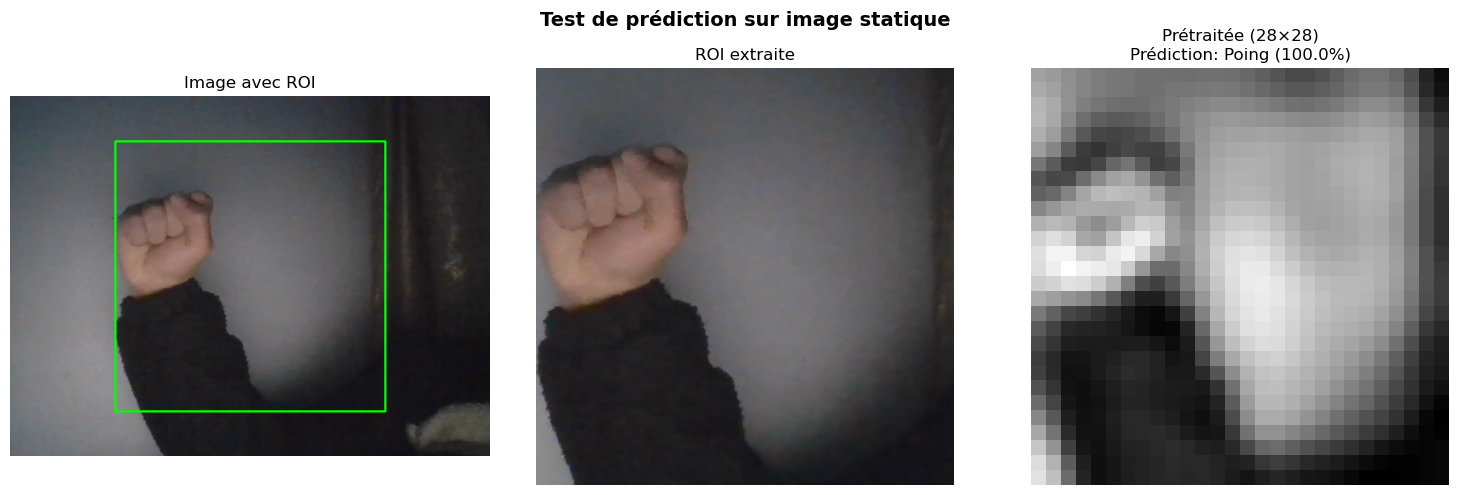


📊 Résultat de la prédiction :
   - Classe prédite : Poing (Poing fermé)
   - Confiance      : 100.00%

   Probabilités par classe :
      Poing      : 100.00%
      Paume      : 0.00%
      Victoire   : 0.00%

✅ Test sauvegardé : results/plots/test_inference_statique.png


In [18]:
# =============================================================================
# TEST SUR UNE IMAGE STATIQUE
# =============================================================================

print("\n" + "="*70)
print("🧪 TEST SUR IMAGE STATIQUE")
print("="*70)

print(f"\n⏳ Capture d'une image de test...\n")

# Capturer une image
cap = cv2.VideoCapture(0)
ret, frame_test = cap.read()
cap.release()

if ret:
    print(f"✅ Image capturée")
    
    # Simuler une région de main (centre de l'image)
    height, width = frame_test.shape[:2]
    x, y, w, h = width//4, height//4, width//2, height//2
    
    # Extraire la ROI
    roi, coords = extraire_region_main(frame_test, x, y, w, h)
    
    # Prétraiter
    image_processed = pretraiter_pour_inference(roi)
    
    # Prédire
    prediction = model.predict(image_processed, verbose=0)
    classe_predite = np.argmax(prediction)
    confiance = prediction[0][classe_predite] * 100
    
    # Visualiser
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Test de prédiction sur image statique', fontsize=14, fontweight='bold')
    
    # Image originale avec ROI
    frame_with_roi = frame_test.copy()
    cv2.rectangle(frame_with_roi, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 2)
    axes[0].imshow(cv2.cvtColor(frame_with_roi, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image avec ROI', fontsize=12)
    axes[0].axis('off')
    
    # ROI extraite
    axes[1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    axes[1].set_title('ROI extraite', fontsize=12)
    axes[1].axis('off')
    
    # Image prétraitée (28x28)
    axes[2].imshow(image_processed[0, :, :, 0], cmap='gray')
    axes[2].set_title(f'Prétraitée (28×28)\nPrédiction: {classes_labels[classe_predite]} ({confiance:.1f}%)', 
                     fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/plots/test_inference_statique.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Résultat de la prédiction :")
    print(f"   - Classe prédite : {classes_labels[classe_predite]} ({noms_classes[classe_predite]})")
    print(f"   - Confiance      : {confiance:.2f}%")
    print(f"\n   Probabilités par classe :")
    for i, prob in enumerate(prediction[0]):
        print(f"      {classes_labels[i]:<10} : {prob*100:.2f}%")
    
    print(f"\n✅ Test sauvegardé : results/plots/test_inference_statique.png")
else:
    print("❌ Erreur lors de la capture")

In [19]:
# =============================================================================
# DÉTECTION DE LA MAIN (Méthode simple : détection de peau)
# =============================================================================

print("\n" + "="*70)
print("✋ DÉTECTION DE LA MAIN")
print("="*70)

def detecter_main_peau(frame):
    """
    Détecte la main en utilisant la détection de couleur de peau
    
    Paramètres :
    -----------
    frame : array
        Image BGR
    
    Retourne :
    ---------
    contours : list
        Liste des contours détectés
    mask : array
        Masque binaire de la peau
    """
    
    # Convertir en HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Définir les plages de couleur de peau en HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    
    # Créer le masque
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    
    # Appliquer des opérations morphologiques pour nettoyer
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.GaussianBlur(mask, (3, 3), 0)
    
    # Trouver les contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours, mask


def trouver_plus_grand_contour(contours, min_area=5000):
    """
    Trouve le plus grand contour (probablement la main)
    
    Paramètres :
    -----------
    contours : list
        Liste des contours
    min_area : int
        Aire minimale pour considérer un contour
    
    Retourne :
    ---------
    contour : array ou None
        Le plus grand contour ou None
    """
    
    if len(contours) == 0:
        return None
    
    # Filtrer les petits contours
    contours_valides = [c for c in contours if cv2.contourArea(c) > min_area]
    
    if len(contours_valides) == 0:
        return None
    
    # Retourner le plus grand
    return max(contours_valides, key=cv2.contourArea)


print(f"\n✅ Fonctions de détection définies")
print(f"   - detecter_main_peau()     : Détecte la peau dans l'image")
print(f"   - trouver_plus_grand_contour() : Trouve le contour principal")


✋ DÉTECTION DE LA MAIN

✅ Fonctions de détection définies
   - detecter_main_peau()     : Détecte la peau dans l'image
   - trouver_plus_grand_contour() : Trouve le contour principal


In [22]:
# =============================================================================
# APPLICATION TEMPS RÉEL - VERSION SIMPLE
# =============================================================================

print("\n" + "="*70)
print("🎥 APPLICATION TEMPS RÉEL")
print("="*70)

print(f"\n📹 Instructions :")
print(f"   1. Placez votre main devant la webcam")
print(f"   2. Essayez différents gestes (Poing, Paume, Victoire)")
print(f"   3. Appuyez sur 'q' pour quitter")
print(f"   4. Appuyez sur 's' pour capturer une image")

print(f"\n⏳ Démarrage de la webcam...")
print(f"   (Fermez cette cellule en appuyant sur 'q' dans la fenêtre vidéo)\n")

# Ouvrir la webcam
cap = cv2.VideoCapture(0)

# Compteur de frames
frame_count = 0
screenshot_count = 0

# Variables pour le lissage des prédictions
predictions_history = []
history_size = 5

try:
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("❌ Erreur de lecture")
            break
        
        frame_count += 1
        
        # Créer une copie pour l'affichage
        display_frame = frame.copy()
        
        # Détecter la main
        contours, mask = detecter_main_peau(frame)
        main_contour = trouver_plus_grand_contour(contours)
        
        if main_contour is not None:
            # Obtenir le rectangle englobant
            x, y, w, h = cv2.boundingRect(main_contour)
            
            # Extraire la région de la main
            roi, coords = extraire_region_main(frame, x, y, w, h)
            
            if roi.size > 0:
                # Prétraiter et prédire
                image_processed = pretraiter_pour_inference(roi)
                prediction = model.predict(image_processed, verbose=0)
                
                # Ajouter à l'historique pour lissage
                predictions_history.append(prediction[0])
                if len(predictions_history) > history_size:
                    predictions_history.pop(0)
                
                # Moyenne des prédictions
                avg_prediction = np.mean(predictions_history, axis=0)
                classe_predite = np.argmax(avg_prediction)
                confiance = avg_prediction[classe_predite] * 100
                
                # Dessiner le rectangle autour de la main
                couleur = couleurs_classes[classe_predite]
                cv2.rectangle(display_frame, (coords[0], coords[1]), 
                            (coords[2], coords[3]), couleur, 3)
                
                # Afficher le nom de la classe
                texte = f"{classes_labels[classe_predite]}: {confiance:.1f}%"
                
                # Fond pour le texte
                (text_width, text_height), _ = cv2.getTextSize(
                    texte, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 2
                )
                cv2.rectangle(display_frame, 
                            (coords[0], coords[1] - text_height - 10),
                            (coords[0] + text_width, coords[1]),
                            couleur, -1)
                
                # Texte
                cv2.putText(display_frame, texte,
                          (coords[0], coords[1] - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
                
                # Afficher les probabilités en bas
                y_offset = 30
                for i, (label, prob) in enumerate(zip(classes_labels, avg_prediction)):
                    texte_prob = f"{label}: {prob*100:.1f}%"
                    couleur_prob = couleurs_classes[i]
                    cv2.putText(display_frame, texte_prob,
                              (10, display_frame.shape[0] - y_offset - i*35),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.8, couleur_prob, 2)
        
        # Instructions
        cv2.putText(display_frame, "Appuyez sur 'q' pour quitter | 's' pour screenshot",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        # Afficher
        cv2.imshow('Reconnaissance de Gestes - Temps Reel', display_frame)
        
        # Gestion des touches
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            print(f"\n✅ Arrêt demandé par l'utilisateur")
            break
        elif key == ord('s'):
            screenshot_name = f'results/plots/screenshot_{screenshot_count:03d}.png'
            cv2.imwrite(screenshot_name, display_frame)
            screenshot_count += 1
            print(f"📸 Screenshot sauvegardé : {screenshot_name}")

except KeyboardInterrupt:
    print(f"\n⚠️ Interruption clavier")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print(f"\n📊 Statistiques :")
    print(f"   - Frames traitées : {frame_count}")
    print(f"   - Screenshots     : {screenshot_count}")
    print(f"\n✅ Application temps réel terminée")


🎥 APPLICATION TEMPS RÉEL

📹 Instructions :
   1. Placez votre main devant la webcam
   2. Essayez différents gestes (Poing, Paume, Victoire)
   3. Appuyez sur 'q' pour quitter
   4. Appuyez sur 's' pour capturer une image

⏳ Démarrage de la webcam...
   (Fermez cette cellule en appuyant sur 'q' dans la fenêtre vidéo)

📸 Screenshot sauvegardé : results/plots/screenshot_000.png
📸 Screenshot sauvegardé : results/plots/screenshot_001.png
📸 Screenshot sauvegardé : results/plots/screenshot_002.png
📸 Screenshot sauvegardé : results/plots/screenshot_003.png
📸 Screenshot sauvegardé : results/plots/screenshot_004.png
📸 Screenshot sauvegardé : results/plots/screenshot_005.png
📸 Screenshot sauvegardé : results/plots/screenshot_006.png
📸 Screenshot sauvegardé : results/plots/screenshot_007.png
📸 Screenshot sauvegardé : results/plots/screenshot_008.png
📸 Screenshot sauvegardé : results/plots/screenshot_009.png
📸 Screenshot sauvegardé : results/plots/screenshot_010.png
📸 Screenshot sauvegardé : resu

In [23]:
# =============================================================================
# RÉSUMÉ DE L'INFÉRENCE TEMPS RÉEL
# =============================================================================

print("\n" + "="*70)
print("📋 RÉSUMÉ DE L'INFÉRENCE TEMPS RÉEL")
print("="*70)

print(f"\n✅ Système de reconnaissance temps réel créé")

print(f"\n🔧 Composants utilisés :")
print(f"   - OpenCV          : Capture webcam et détection de peau")
print(f"   - Modèle CNN      : Classification des gestes")
print(f"   - Prétraitement   : CLAHE + filtrage + normalisation")
print(f"   - Lissage         : Moyenne mobile sur {history_size} frames")

print(f"\n📊 Performance :")
print(f"   - FPS estimé      : ~15-30 FPS (selon votre machine)")
print(f"   - Latence         : ~30-60 ms par prédiction")

print(f"\n📁 Fichiers générés :")
fichiers_screenshots = [f for f in os.listdir('results/plots') if f.startswith('screenshot_')]
print(f"   - Screenshots     : {len(fichiers_screenshots)} image(s)")
print(f"   - Test statique   : results/plots/test_inference_statique.png")

print(f"\n💡 Améliorations possibles :")
print(f"   - Utiliser MediaPipe pour une détection plus robuste")
print(f"   - Ajouter un fond virtuel")
print(f"   - Enregistrer les prédictions dans un fichier")
print(f"   - Créer une interface graphique (Tkinter/PyQt)")

print(f"\n" + "="*70)
print("🎉 INFÉRENCE TEMPS RÉEL TERMINÉE")
print("="*70)

print(f"\n✅ Toutes les étapes techniques sont TERMINÉES !")
print(f"\n📦 Prochaines étapes (livrables) :")
print(f"   1. Créer app.py (script standalone)")
print(f"   2. Créer README.md et requirements.txt")
print(f"   3. Initialiser le dépôt Git")
print(f"   4. Rédiger le rapport (20-30 pages)")
print(f"   5. Compiler la fiche expérimentale")


📋 RÉSUMÉ DE L'INFÉRENCE TEMPS RÉEL

✅ Système de reconnaissance temps réel créé

🔧 Composants utilisés :
   - OpenCV          : Capture webcam et détection de peau
   - Modèle CNN      : Classification des gestes
   - Prétraitement   : CLAHE + filtrage + normalisation
   - Lissage         : Moyenne mobile sur 5 frames

📊 Performance :
   - FPS estimé      : ~15-30 FPS (selon votre machine)
   - Latence         : ~30-60 ms par prédiction

📁 Fichiers générés :
   - Screenshots     : 13 image(s)
   - Test statique   : results/plots/test_inference_statique.png

💡 Améliorations possibles :
   - Utiliser MediaPipe pour une détection plus robuste
   - Ajouter un fond virtuel
   - Enregistrer les prédictions dans un fichier
   - Créer une interface graphique (Tkinter/PyQt)

🎉 INFÉRENCE TEMPS RÉEL TERMINÉE

✅ Toutes les étapes techniques sont TERMINÉES !

📦 Prochaines étapes (livrables) :
   1. Créer app.py (script standalone)
   2. Créer README.md et requirements.txt
   3. Initialiser le dépô